In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Convolution2D, Dropout, Input, GlobalAveragePooling2D, MaxPooling2D, Flatten, Dense# Sequential model for building a linear stack of layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#!unzip drive/My\ Drive/images.zip

In [ ]:
sys.path.append('/content/drive/MyDrive/face2face/functions')

In [ ]:
from create_dataframe import create_df

In [ ]:
train_meta = create_df('train')
valid_meta = create_df('valid')
test_meta = create_df('test')

In [ ]:
# Specify the base path where your image data is stored
base_path = '/content/real_vs_fake/real-vs-fake/'


# Create an ImageDataGenerator for image preprocessing and augmentation
image_gen = ImageDataGenerator(rescale=1./255.,
                               horizontal_flip=True)


In [ ]:
VGG16_train = image_gen.flow_from_directory(
    base_path + 'train/',
    target_size=(224, 224),
    batch_size=128,
    class_mode='binary'
)
VGG16_valid = image_gen.flow_from_directory(
    base_path + 'valid/',
    target_size=(224, 224),
    batch_size=128,
    class_mode='binary'
)
VGG16_test = image_gen.flow_from_directory(
    base_path + 'test/',
    target_size=(224, 224),
    batch_size=128,
    class_mode='binary',
    shuffle=False
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
  layer.trainable=False

In [ ]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 14846273 (56.63 MB)
Trainable params: 131585 (514.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________

In [ ]:
learning_rate = 0.0001

In [ ]:
model.compile(optimizer=Adam(learning_rate = learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(VGG16_train, epochs=100, validation_data=(VGG16_valid), callbacks=[early_stopping])

Epoch 1/100
782/782 [==============================] - 546s 669ms/step - loss: 0.6395 - accuracy: 0.6329 - val_loss: 0.6024 - val_accuracy: 0.6787
Epoch 2/100
782/782 [==============================] - 535s 683ms/step - loss: 0.5937 - accuracy: 0.6869 - val_loss: 0.5732 - val_accuracy: 0.7049
Epoch 3/100
782/782 [==============================] - 535s 684ms/step - loss: 0.5691 - accuracy: 0.7081 - val_loss: 0.5527 - val_accuracy: 0.7222
Epoch 4/100
782/782 [==============================] - 536s 685ms/step - loss: 0.5509 - accuracy: 0.7230 - val_loss: 0.5363 - val_accuracy: 0.7335
Epoch 5/100
782/782 [==============================] - 536s 685ms/step - loss: 0.5371 - accuracy: 0.7332 - val_loss: 0.5253 - val_accuracy: 0.7403
Epoch 6/100
782/782 [==============================] - 535s 684ms/step - loss: 0.5283 - accuracy: 0.7387 - val_loss: 0.5184 - val_accuracy: 0.7476
Epoch 7/100
782/782 [==============================] - 535s 685ms/step - loss: 0.5205 - accuracy: 0.7449 - val_loss: 0

In [ ]:
import pickle
with open('/content/drive/MyDrive/face2face/models/VGG16_history.pkl', 'wb') as f:
  pickle.dump(history.history, f)
with open('/content/drive/MyDrive/face2face/models/VGG16.pkl', 'wb') as f:
    pickle.dump(model, f)

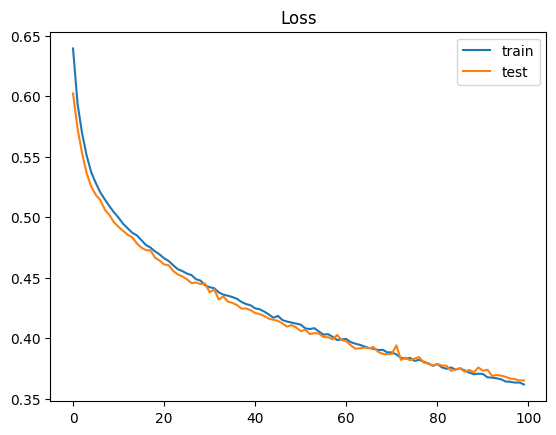

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('Loss')
plt.show()

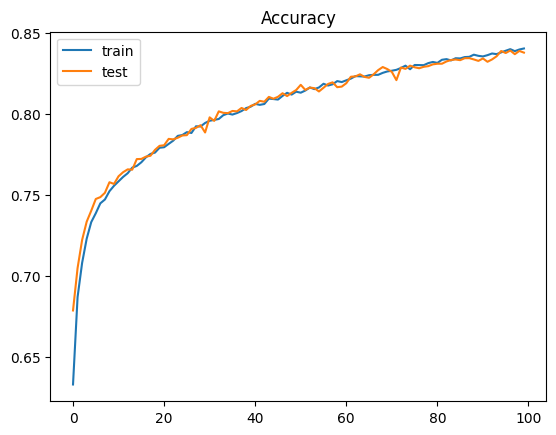

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.title('Accuracy')
plt.show()

In [ ]:
import pickle
with open('/content/drive/MyDrive/face2face/models/VGG16.pkl', 'rb') as f:
    model = pickle.load(f)

In [ ]:
model.evaluate(VGG16_test)

157/157 [==============================] - 101s 505ms/step - loss: 0.3674 - accuracy: 0.8356


[0.3674447536468506, 0.8355500102043152]

In [ ]:
y_true = VGG16_test.classes
y_pred = model.predict(VGG16_test)

157/157 [==============================] - 80s 511ms/step


In [ ]:
y_pred_labels = (y_pred > 0.5).astype(int)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
cm = confusion_matrix(y_true, y_pred_labels)

In [ ]:
VGG16_metrics = classification_report(y_true, y_pred_labels)

In [ ]:
print(VGG16_metrics)

              precision    recall  f1-score   support

           0       0.84      0.83      0.84     10000
           1       0.83      0.84      0.84     10000

    accuracy                           0.84     20000
   macro avg       0.84      0.84      0.84     20000
weighted avg       0.84      0.84      0.84     20000



In [ ]:
accuracy_score(y_true, y_pred_labels), precision_score(y_true, y_pred_labels), recall_score(y_true, y_pred_labels), f1_score(y_true, y_pred_labels)

(0.83675, 0.8348414039972158, 0.8396, 0.8372139402702298)

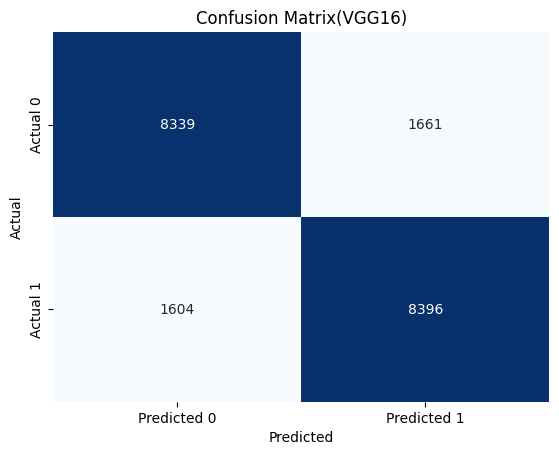

In [ ]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix(VGG16)")
plt.show()